# Universalidad de la corrupción
En esta sección se programa el modelo propuesto por los investigadores para recrear las redes de tipo corruptas.

In [16]:
# Instalar las librerías necesarias
# %pip install networkx
# %pip install matplotlib
# %pip install scipy
# %pip install scienceplots
%pip install pyvis

  Using cached pyvis-0.3.2-py3-none-any.whl.metadata (1.7 kB)
  Using cached jinja2-3.1.5-py3-none-any.whl.metadata (2.6 kB)
Using cached pyvis-0.3.2-py3-none-any.whl (756 kB)
Using cached jinja2-3.1.5-py3-none-any.whl (134 kB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
#Modelo creado paso a paso
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt
from pyvis.network import Network

def modeloRedCorruptaMartinsEtal(num_iterations, characteristic_size, recidivism_rate, beta, p):
    """
    Simula una red de corrupción usando el modelo propuesto por los investigadores.

    Parámetros:
    num_iterations (int): Número de iteraciones (escándalos) a simular.
    characteristic_size (int): Tamaño característico de los escándalos de corrupción.
    recidivism_rate (float): Tasa de reincidencia.
    beta (int): Controla el número mínimo de personas necesarias para la aparición de los primeros agentes reincidentes.
    p (float): Probabilidad de seleccionar nodos que ya eran reincidentes.

    Devuelve:
    nx.Graph: La red de corrupción simulada.
    """
    
    # Se definen las variables al inicio de la función
    total_nodes = 0
    reincidentes = []
    nodos_reincidentes = []
    nodos_no_reincidentes = []
    nodos_red = []
    nuevos_nodos_reincidentes = []
    nuevos_nodos_escandalo = []

    # Se crea una red vacía
    graph = nx.Graph()

    # Se simulan los escándalos
    
    for i in range(num_iterations):
        
        #Se añaden redes completas que representan escándalos políticos en cada iteración. El número de personas o el tamaño de estos gráficos completos se extrae al azar de una distribución exponencial (P) para imitar el comportamiento empírico (Fig. 1), es decir, P (S) ∼ e^( − S/SC)   , donde SC representa el tamaño característico (empíricamente ≈ 7 personas). 

        # Obtener el tamaño del escándalo de una distribución exponencial
        tamano_escandalo = int(random.expovariate(1.0 / characteristic_size)) 

        if tamano_escandalo > 1:
            # Crear un grafo completo con el tamaño del escándalo
            nuevo_grafo_escandalo = nx.complete_graph(tamano_escandalo)
            nuevos_nodos_escandalo = list(nuevo_grafo_escandalo.nodes())
            
            # Añadir la red completa a la red general
            graph = nx.disjoint_union(graph, nuevo_grafo_escandalo)
            nodos_red = list(graph.nodes())

            # Unir los nuevos nodos del escándalo con los nodos reincidentes de la anterior iteración
            # Se añaden aristas entre los nodos del escándalo y los nodos reincidentes de la iteración anterior
            for nodo in nuevos_nodos_escandalo:
                for nodo_reincidente_iteración_anterior in nuevos_nodos_reincidentes:
                    graph.add_edge(nodo, nodo_reincidente_iteración_anterior) 

            # Se reinician los nodos reincidentes de la iteración anterior
            nuevos_nodos_reincidentes = [] 
            
            # Calcular el número de nodos reincidentes
            
            # Calcular el número total de nodos en la red
            total_nodes = graph.number_of_nodes()
            # Calcular el número de nodos reincidentes por medio de la formula dada en el artículo        
            r = max(0, int(recidivism_rate * total_nodes - beta))  # Se asegura que el número de reincidentes sea un entero positivo
            
            # Seleccionar nodos para convertirlos en reincidentes

            # Seleccionamos al azar nodos ya presentes en la red para convertirlos en reincidentes y hacer que pertenezcan al siguiente escándalo

            if r > 0:
                # Cuando es la primera ocasión que aparecen nodos reincidentes
                if len(nodos_reincidentes) == 0:
                    # Seleccionar al azar nodos de la red
                    reincidentes = random.sample(list(graph.nodes()), r)

                    #Etiquetar nodos reincidentes
                    for nodo in reincidentes:
                        graph.nodes[nodo]['reincidente'] = 1
                
                    #Añadir los nodos etiquetados como reincidentes a una lista
                    nodos_reincidentes = [nodo for nodo in graph if graph.nodes[nodo].get('reincidente', 0) == 1]
                    
                    #Añadir los nodos etiquetados como no reincidentes a una lista
                    nodos_no_reincidentes = [nodo for nodo in graph if graph.nodes[nodo].get('reincidente', 0) == 0]

                #Cuando ya existen nodos reincidentes en la red
                else:
                    #Seleccionar nodos que ya eran reincidentes con una pequeña probabilidad 'p' o nodos que se convertirán en reincidentes por primera vez con probabilidad '1−p' 

                    #Se asignan probabilidades a los nodos reincidentes y no reincidentes
                    probabilidades = [(1 - p)] * len(nodos_reincidentes) + [p] * len(nodos_no_reincidentes)
                    probabilidades = np.array(probabilidades) / np.sum(probabilidades) 
                    
                    # Seleccionar nodos para convertirlos en reincidentes
                    
                    #Seleccionamos todos los nodos de la red
                    #nodos_red_iteracion_pasada = list(set(nodos_red) - set(nuevos_nodos_escandalo))

                    #Seleccionamos los nodos reincidentes con las probabilidades asignadas
                    nodos_red = nodos_reincidentes + nodos_no_reincidentes

                    nuevos_nodos_reincidentes = np.random.choice( 
                            nodos_red,
                            size= r,
                            replace=False,
                            p=probabilidades)
                    
                    #Se añaden a una lista temporal para unirlos a la red completa en la siguiente iteración
                    nuevos_nodos_reincidentes = list(nuevos_nodos_reincidentes) # Convertir a lista normal

                    #Etiquetarlos como reincidentes
                    for nodo in nuevos_nodos_reincidentes:
                        graph.nodes[nodo]['reincidente'] = 1
                    #Añadir los nodos etiquetados como reincidentes a la lista de nodos reincidentes
                    nodos_reincidentes = [nodo for nodo in graph if graph.nodes[nodo].get('reincidente', 0) == 1]

    return graph

################################################################################

# Ejemplo de uso con el caso de Brasil

#Brazilian network comprises 404 nodes, 3549 edges, 14 connected components, and a giant component accounting for 77% of nodes and 93% of edges.

num_iterations = 65  # Número de escándalos en Brasil 
characteristic_size = 7 # Tamaño característico de los escándalos en Brasil
recidivism_rate = 0.065  # Tasa de reincidencia ajustada para el correcto funcionamiento del modelo (leer el artículo)
beta = 12 # Controla el número mínimo de personas necesarias para la aparición de los primeros agentes reincidentes
p = 0.025 # Probabilidad de seleccionar nodos que ya eran reincidentes

corruption_network_brazil = modeloRedCorruptaMartinsEtal(num_iterations, characteristic_size, recidivism_rate, beta, p)

print(f"Número de nodos en la red: {corruption_network_brazil.number_of_nodes()}")
print(f"Número de aristas en la red: {corruption_network_brazil.number_of_edges()}")

# Visualizar la red creada usando mathplotlib
import matplotlib.pyplot as plt
nx.draw(corruption_network_brazil, with_labels=False, node_size=1)
plt.show()

ModuleNotFoundError: No module named 'networkx'

In [19]:
# Visualizar la red creada usando pyvis

from pyvis.network import Network

# Crear una instancia de Network con opciones de visualización personalizadas
net = Network(notebook=True, height='100vh', width="100%", select_menu=True, filter_menu=True)

# Añadir nodos y aristas a la visualización
for node in final_network.nodes():
    net.add_node(int(node), label=str(node))

for edge in final_network.edges():
    net.add_edge(int(edge[0]), int(edge[1]))

#Mostrar botones de personalización
net.show_buttons()

# Guardar la visualización en un archivo HTML
net.show("final_network.html")

final_network.html


#### Métricas de la red Brasileña creada con el modelo propuesto en 'Universalidad de la corrupción'

Ahora se corroborarán las métricas de la red por medio de la función metricasRed() creada en el archivo 'Metricas.ipynb'

In [12]:
#Se crea la función que calcula todas las métricas de la red

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import scienceplots
from networkx.algorithms import community

#Funcion para graficar la red

def mostrarRed(G,nombre):
    
    plt.style.use('science')

    plt.figure(figsize=(4, 4))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, node_size=50, node_color='#9FA3D5', edge_color='#3B4285', with_labels=False)
    plt.title(f'Red: {nombre}')
    plt.savefig(f'red_{nombre}.png', dpi=300)
    plt.show()

#Funcion para graficar la distribución de grados

def distribucionDeGrado(G, nombre):
    # Obtener los grados de los nodos y calcular la distribución de frecuencia
    degrees = list(dict(nx.degree(G)).values())
    unique_degrees, counts = np.unique(degrees, return_counts=True)
    probs = counts / len(G)

    # Eliminar grados con frecuencia cero
    non_zero_probs = probs[probs > 0]
    non_zero_degrees = unique_degrees[probs > 0]

    # Tomar el logaritmo de las probabilidades y los grados
    log_probs = np.log(non_zero_probs)
    log_degrees = np.log(non_zero_degrees)

    # Realizar un ajuste lineal
    slope, intercept, r_value, p_value, std_err = linregress(log_degrees, log_probs)

    # Calcular el exponente de la ley de potencias
    gamma = round(slope,2)
    
    # Crear el gráfico

    plt.style.use('science')

    # Graficar con escala logarítmica únicamente en el eje y (Distribución de grados en una red)
    plt.figure(figsize=(4, 4))

    plt.plot(non_zero_degrees, non_zero_probs, 'o-', color='#3B4285')
    plt.yscale('log')
    plt.xlabel('Grado')
    plt.ylabel('Probabilidad')
    plt.title('Distribución de grados')
    plt.legend()

    plt.savefig(f'distribucion_de_grados_{nombre}.png', dpi=300)
    plt.show()
    
    plt.figure(figsize=(4, 4)) 

    plt.loglog(unique_degrees, probs, 'o', color='#9FA3D5')
    plt.plot(unique_degrees, np.exp(intercept + slope * np.log(unique_degrees)), '--', label='Ajuste lineal', color='#3B4285')

    plt.xlabel('Grado (log)')
    plt.ylabel('Probabilidad (log)')
    plt.legend()
    plt.title('Distribución de grados (escala logarítmica)')

    # Guardar el gráfico con mayor resolución
    plt.savefig(f'distribucion_de_grados_log_{nombre}.png', dpi=300)
    plt.show()
    
    # Imprimir el exponente
    print("Exponente de la ley de potencias (gamma):", gamma)    

#Función para calcular la estructura en comunidades

def estructuraComunidades(G, nombre):
    # Detectar comunidades usando el algoritmo de detección de comunidades de Louvain
    comunidades = community.louvain_communities(G)

    # Número de comunidades
    num_comunidades = len(comunidades)
    
    #Cantidad de nodos en cada comunidad
    nodos_comunidad = [len(comunidad) for comunidad in comunidades]
    
    # Promedio de nodos por comunidad
    promedio_nodos = round(np.mean(nodos_comunidad),2)

    # Crear un diccionario de colores para las comunidades
    color_map = {}
    for i, comunidad in enumerate(comunidades):
        for node in comunidad:
            color_map[node] = i
            
    # Crear el gráfico de la red con colores para las comunidades
    plt.figure(figsize=(4, 4)) # Tamaño del gráfico
    pos = nx.spring_layout(G)
    nx.draw(G, pos, node_size=50, node_color=list(color_map.values()), edge_color='gray', with_labels=False, cmap=plt.cm.tab20)
    plt.title(f'Red: {nombre} (Comunidades)')
    plt.savefig(f'comunidades_{nombre}.png', dpi=300)
    plt.show()
    
    # Imprimir el número de comunidades y el tamaño de cada una
    print(f"Número de comunidades: {num_comunidades}")
    print(f"Número de nodos por comunidad: {nodos_comunidad}")
    print(f"Promedio de nodos por comunidad: {promedio_nodos}")

    # Encontrar la comunidad más grande
    max_comunidad = max(nodos_comunidad)

    print(f"Comunidad más grande: {max_comunidad} nodos")
    
    #Etiquetar los nodos de la comunidad más grande
    nodos_max_comunidad = [node for node in G.nodes() if node in comunidades[np.argmax(nodos_comunidad)]]
    
    #Seleccionar la red de la comunidad más grande
    G_max_comunidad = G.subgraph(nodos_max_comunidad)
    return G_max_comunidad

         
# Propiedad de mundo pequeño

def mundoPequeno(G, G_max_comunidad, nombre):
    
    # Calcular el coeficiente de agrupamiento global
    clustering_coeff = round(nx.average_clustering(G),2)

    # Calcular el coeficiente de agrupamiento local (comunidad más grande)
    clustering_coeff_local = round(nx.average_clustering(G_max_comunidad),2)
    
    # Calcular el camino medio más corto de la red local
    try:
        average_path_length = round(nx.average_shortest_path_length(G_max_comunidad),2)
    except nx.NetworkXError:
        average_path_length = round(float('inf'),2)

    print(f"Coeficiente de agrupamiento global: {clustering_coeff}")
    print(f"Coeficiente de agrupamiento local: {clustering_coeff_local}")
    print(f"Camino medio más corto: {average_path_length}")
    
    if  (clustering_coeff_local > .90 and average_path_length < 5):
        print(f"La red '{nombre}' tiene la propiedad de mundo pequeño.")
    else:
        print(f"La red '{nombre}' no tiene la propiedad de mundo pequeño.")
    
#Asortaividad

def asortatividad(G, G_max_comunidad):
    # Calcular el coeficiente de asortatividad de grado global
    assortativity_coeff = round(nx.degree_assortativity_coefficient(G),2)
    # Calcular el coeficiente de asortatividad de grado local
    assortativity_coeff_local = round(nx.degree_assortativity_coefficient(G_max_comunidad),2)
    # Imprimir los coeficientes de asortatividad
    print(f"Coeficiente de Asortatividad Global: {assortativity_coeff}")
    print(f"Coeficiente de Asortatividad Local: {assortativity_coeff_local}")
 
def densidad(G, G_max_comunidad):
    # Calcular la densidad de la red global
    density = round(nx.density(G), 2)
    # Calcular la densidad de la red local
    density_local = round(nx.density(G_max_comunidad), 2)
    # Imprimir la densidad
    print(f"Densidad de la red global: {density}")
    print(f"Densidad de la red: {density_local}")
    
#Función global que calcula todas las métricas
            
def metricasRed(G, nombre):
    # Mostrar la red
    mostrarRed(G, nombre)
    # Obtener los grados de los nodos y calcular la distribución de frecuencia
    distribucionDeGrado(G, nombre)
    # Estructura en comunidades
    G_max_comunidad = estructuraComunidades(G, nombre)
    # Propiedad de mundo pequeño
    mundoPequeno(G, G_max_comunidad, nombre)
    # Asortatividad
    asortatividad(G, G_max_comunidad)
    # Densidad
    densidad(G, G_max_comunidad)

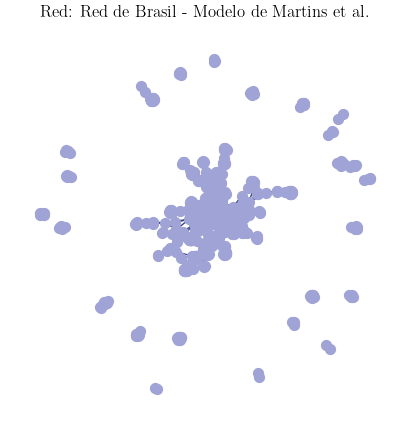

C:\Users\cavn\AppData\Local\Temp\ipykernel_24344\1016749115.py:57: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


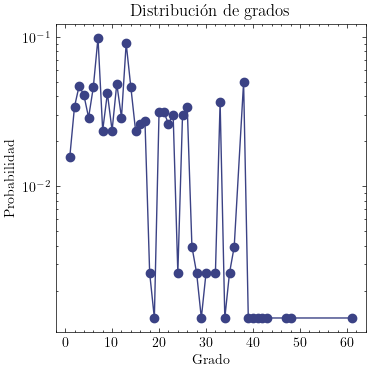

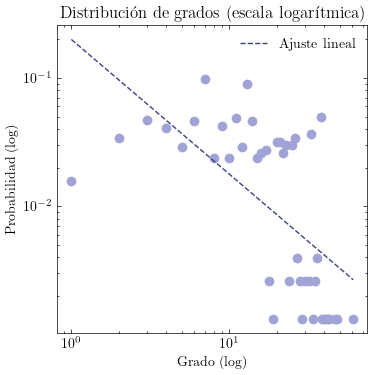

Exponente de la ley de potencias (gamma): -1.05


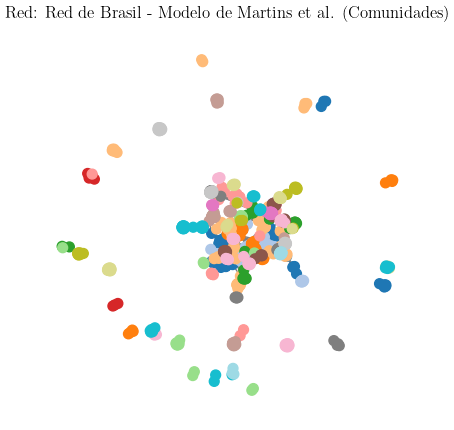

Número de comunidades: 43
Número de nodos por comunidad: [6, 3, 54, 39, 42, 14, 39, 82, 4, 4, 29, 21, 4, 6, 2, 20, 29, 3, 2, 2, 8, 3, 6, 36, 15, 39, 20, 5, 32, 15, 4, 20, 21, 14, 7, 12, 23, 8, 30, 23, 2, 10, 4]
Promedio de nodos por comunidad: 17.72
Comunidad más grande: 82 nodos
Coeficiente de agrupamiento global: 0.93
Coeficiente de agrupamiento local: 0.91
Camino medio más corto: 2.61
La red 'Red de Brasil - Modelo de Martins et al.' tiene la propiedad de mundo pequeño.
Coeficiente de Asortatividad Global: 0.8
Coeficiente de Asortatividad Local: 0.25
Densidad de la red global: 0.02
Densidad de la red: 0.13


In [14]:
#Calcular las métricas de la red de corrupción de Brasil
nombre = 'Red de Brasil - Modelo de Martins et al.'
metricasRed(final_network, nombre)

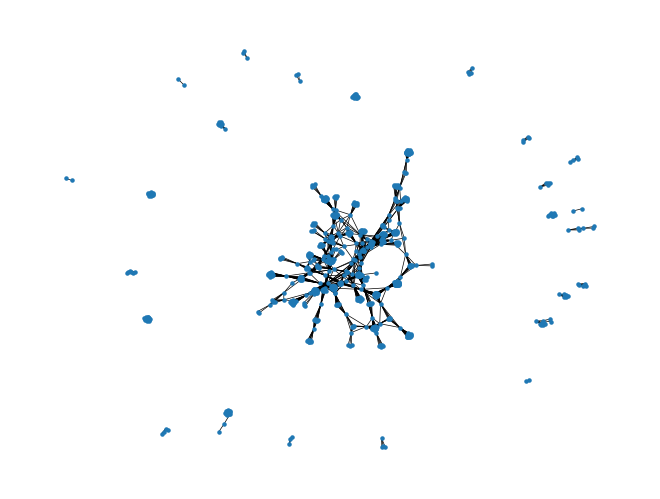

In [9]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt  # Importar matplotlib para visualización con networkx
from itertools import combinations

def generate_net_links(tmax = 100, lambda_ = 7.33, a = 0.09, b = -11.5, proba = 0.024):
    """
    Generate a corruption network based on our model using NetworkX.

    Parameters
    ---------
    ... (igual que la descripción original) ...
    """

    t                          = 0
    links                      = []
    links_list                 = []
    agent_names                = set()
    last_agent_index           = 0
    repeated_agent_names       = set()
    total_repeated_agents      = 0

    while t < tmax:
        n_new_agents = int(np.round(np.random.exponential(lambda_)))

        if n_new_agents > 1:

            new_agent_names     = [x for x in np.arange(last_agent_index, last_agent_index + n_new_agents)]
            last_agent_index   += n_new_agents

            new_repeated_agents = int(np.round((a*(len(agent_names)) + b - total_repeated_agents)))

            if new_repeated_agents > 0:
                for i in range(min(new_repeated_agents, len(new_agent_names))):

                    if (np.random.uniform() <= proba) & (len(repeated_agent_names) > 0):
                        #select from repeated_agent_names
                        repeated_agent = np.random.choice(list(repeated_agent_names))
                    else:
                        #select from agent_names
                        repeated_agent = np.random.choice(list(agent_names.difference(repeated_agent_names))) # Corrección: usar diferencia de conjuntos
                        total_repeated_agents += 1

                    new_agent_names[i] = repeated_agent
                    repeated_agent_names.add(repeated_agent)

            for agent_ in new_agent_names:
                agent_names.add(agent_)

            new_links = list(combinations(new_agent_names, 2))

            links_list += [new_links]
            t          += 1

    return links_list

edge_lists = generate_net_links(tmax = 100, a = 0.142) # e.g, [[(0, 1), (0, 3), ... (5, 6)], [(7, 8), (7, 9) ... (14, 15)], ... ]

def network(t, edges_list):
    g           = nx.Graph() # Crear grafo de networkx
    edge_list_t = np.concatenate(edges_list[:t])

    g.add_edges_from(edge_list_t) # Añadir aristas con networkx

    # Eliminar self loops con networkx
    g.remove_edges_from(nx.selfloop_edges(g))

    # networkx no tiene una función directa para eliminar aristas paralelas
    # En este caso, add_edges_from no añade aristas paralelas duplicadas por defecto,
    # por lo que este paso puede omitirse en networkx si se desea el mismo comportamiento.
    # Si se necesitara eliminar aristas paralelas explícitamente (en caso de que se generaran de otra forma),
    # se requeriría un manejo adicional.

    return g

final_network = network(100, edge_lists)
final_network

# Visualización de la red con networkx y matplotlib

# Calcular la disposición de los nodos con networkx (spring_layout es similar a SFDP)
pos = nx.spring_layout(final_network)

# Dibujar la red con networkx y matplotlib
nx.draw(final_network, pos, node_size=5, width=0.5, with_labels=False) # Ajustar parámetros para networkx

plt.savefig("corruption_network_networkx.png") # Guardar la figura usando matplotlib
plt.show() # Mostrar la figura (opcional)